In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


# Imports

### Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set plotting style
sns.set_style("whitegrid")
print("Libraries imported.")

2025-07-22 23:40:39.051716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753227639.274921      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753227639.345015      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported.


### Downloading NLTK assets

In [3]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

### Data loading & Initial Cleanup

In [4]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
df.dropna(inplace=True)
df.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'], keep='first', inplace=True)
print(f"Data loaded and cleaned. Shape: {df.shape}")

Data loaded and cleaned. Shape: (393914, 10)


In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393914 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393914 non-null  int64 
 1   ProductId               393914 non-null  object
 2   UserId                  393914 non-null  object
 3   ProfileName             393914 non-null  object
 4   HelpfulnessNumerator    393914 non-null  int64 
 5   HelpfulnessDenominator  393914 non-null  int64 
 6   Score                   393914 non-null  int64 
 7   Time                    393914 non-null  int64 
 8   Summary                 393914 non-null  object
 9   Text                    393914 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.1+ MB


# Exploratory Data Analysis

### Class balance Plot

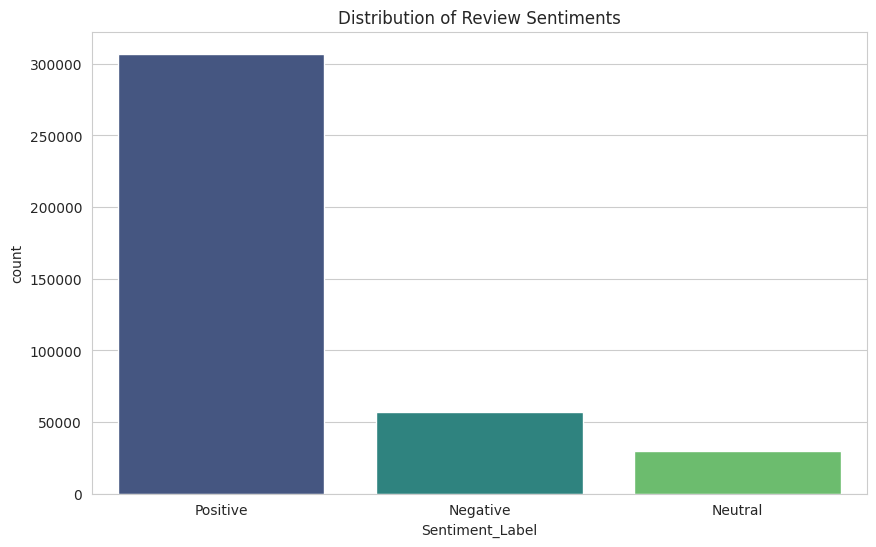

In [7]:
def map_sentiment(score):
    if score >= 4: return 'Positive'
    elif score <= 2: return 'Negative'
    else: return 'Neutral'
df['Sentiment_Label'] = df['Score'].apply(map_sentiment)

plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment_Label', data=df, order=['Positive', 'Negative', 'Neutral'], palette='viridis')
plt.title('Distribution of Review Sentiments')
plt.show()

### Review Length Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


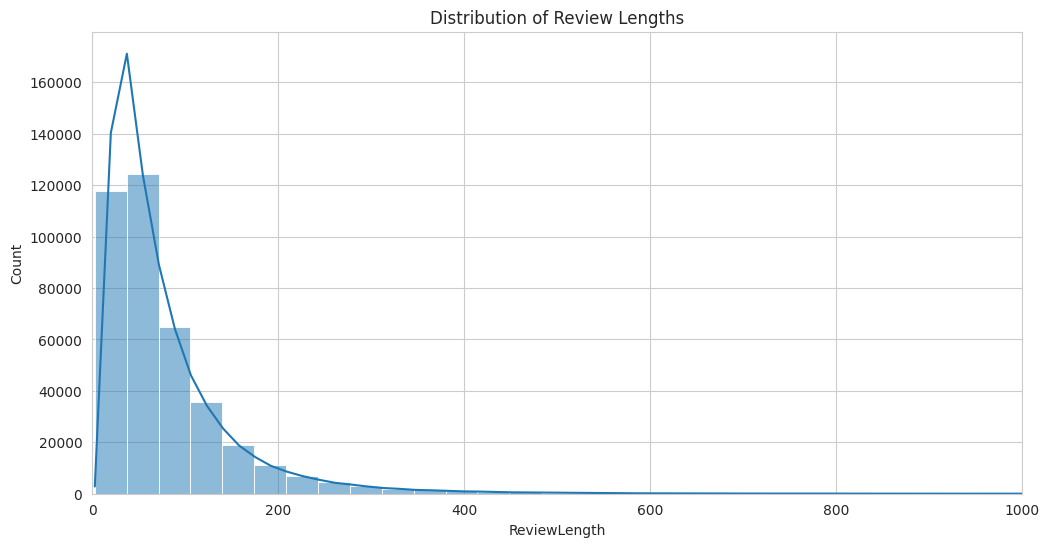

In [8]:
df['ReviewLength'] = df['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(df['ReviewLength'], bins=100, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlim(0, 1000)
plt.show()

### Helpfulness vs. Star Rating

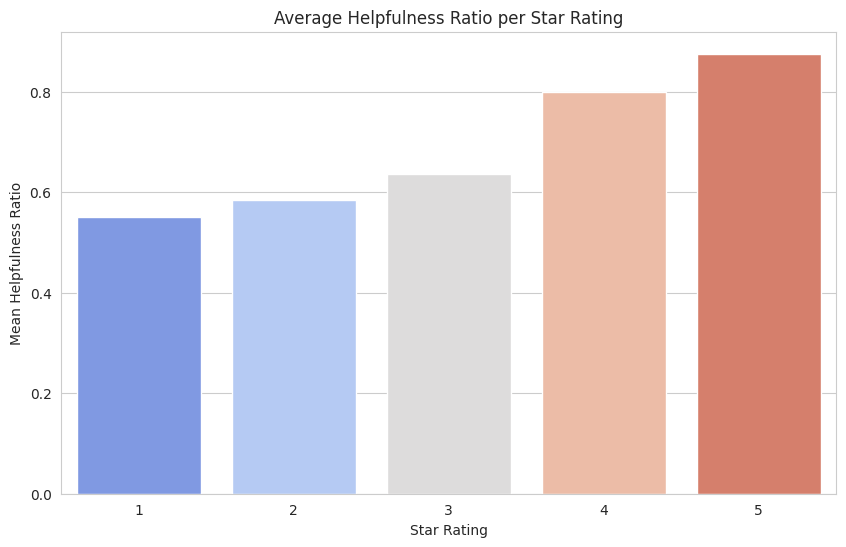

In [9]:
# Calculate the helpfulness ratio, avoiding division by zero
df_eda_helpful = df[df['HelpfulnessDenominator'] > 0].copy()
df_eda_helpful['HelpfulnessRatio'] = df_eda_helpful['HelpfulnessNumerator'] / df_eda_helpful['HelpfulnessDenominator']

# Group by score and calculate the average helpfulness
helpfulness_by_score = df_eda_helpful.groupby('Score')['HelpfulnessRatio'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='HelpfulnessRatio', data=helpfulness_by_score, palette='coolwarm')
plt.title('Average Helpfulness Ratio per Star Rating')
plt.ylabel('Mean Helpfulness Ratio')
plt.xlabel('Star Rating')
plt.show()

### User Behaviour Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


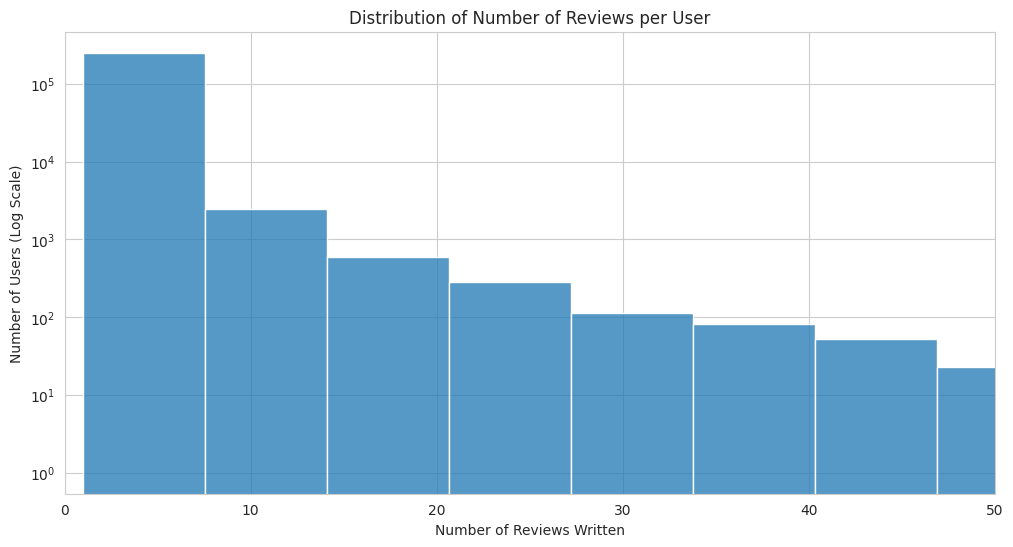

In [10]:
# Group by UserId and count the number of reviews each user has written
reviews_per_user = df.groupby('UserId')['Id'].count()

plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_user, bins=50, log_scale=(False, True))
plt.title('Distribution of Number of Reviews per User')
plt.xlabel('Number of Reviews Written')
plt.ylabel('Number of Users (Log Scale)')
plt.xlim(0, 50) # Zoom in on users with fewer than 50 reviews for clarity
plt.show()

### Analysing data at Product Level

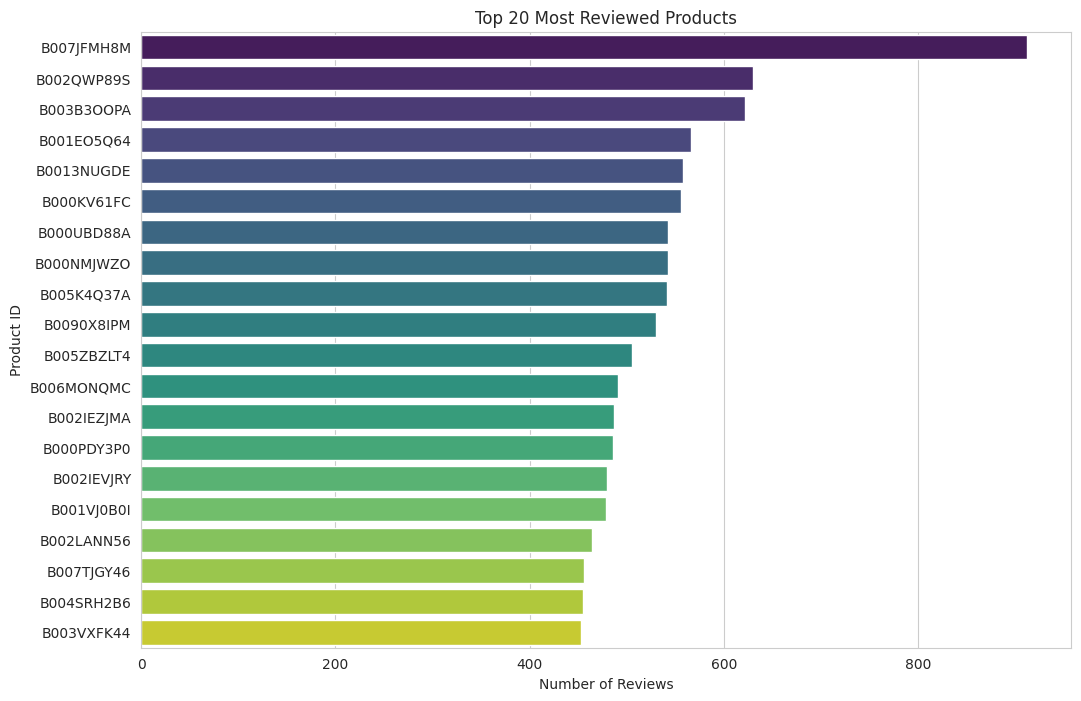

In [11]:
#Top 20 Most Reviewed Product
# Group by ProductId and count the number of reviews
top_products = df.groupby('ProductId')['Id'].count().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_products.index, x=top_products.values, palette='viridis', orient='h')
plt.title('Top 20 Most Reviewed Products')
plt.xlabel('Number of Reviews')
plt.ylabel('Product ID')
plt.show()

# Data Preprocessing

### Creating Target & Filter Reviews

In [12]:
# Creating binary sentiment target: 1 for Positive, 0 for Negative
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else (0 if x <= 2 else -1))

# Filter out neutral reviews and very long reviews
df_filtered = df[df['Sentiment'] != -1].copy()
length_percentile_98 = df_filtered['ReviewLength'].quantile(0.98)
df_filtered = df_filtered[df_filtered['ReviewLength'] <= length_percentile_98]

print(f"Data filtered. Final shape for modeling: {df_filtered.shape}")

Data filtered. Final shape for modeling: (356882, 13)


### EDA - Sentiment vs. Review Length

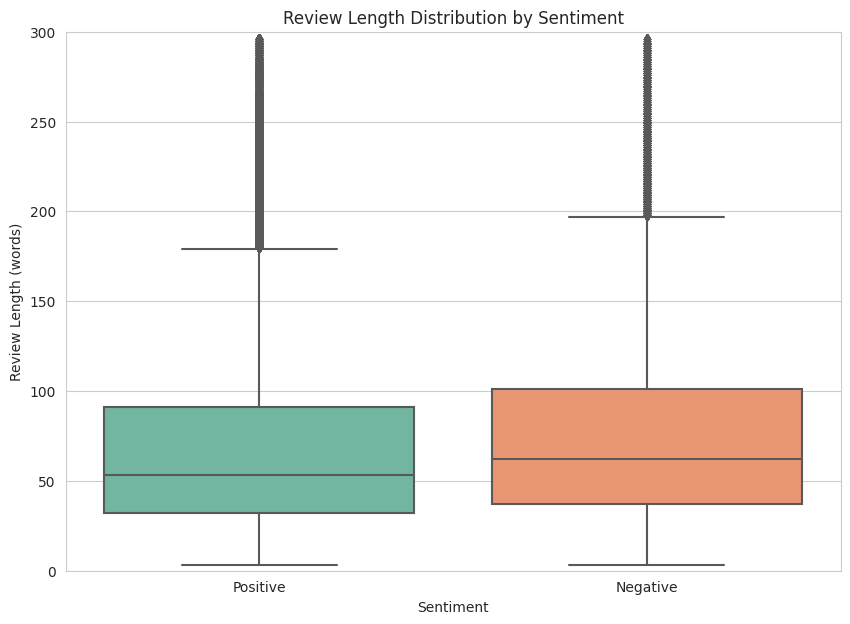

In [13]:
# Mapping the binary sentiment back to labels for plotting
plot_labels = df_filtered['Sentiment'].map({1: 'Positive', 0: 'Negative'})

plt.figure(figsize=(10, 7))
sns.boxplot(x=plot_labels, y=df_filtered['ReviewLength'], palette='Set2')
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (words)')
plt.ylim(0, 300) # Zoom in to see the main distribution
plt.show()

### Text Cleaning

In [14]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))
def clean_text_nltk(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

print("Applying text cleaning...")
df_filtered['CleanedText'] = df_filtered['Text'].apply(clean_text_nltk)
print("Text cleaning complete.")

Applying text cleaning...


/tmp/ipykernel_13/3830234714.py:4: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html.parser").get_text()


Text cleaning complete.


### EDA - Finding Common Phrases

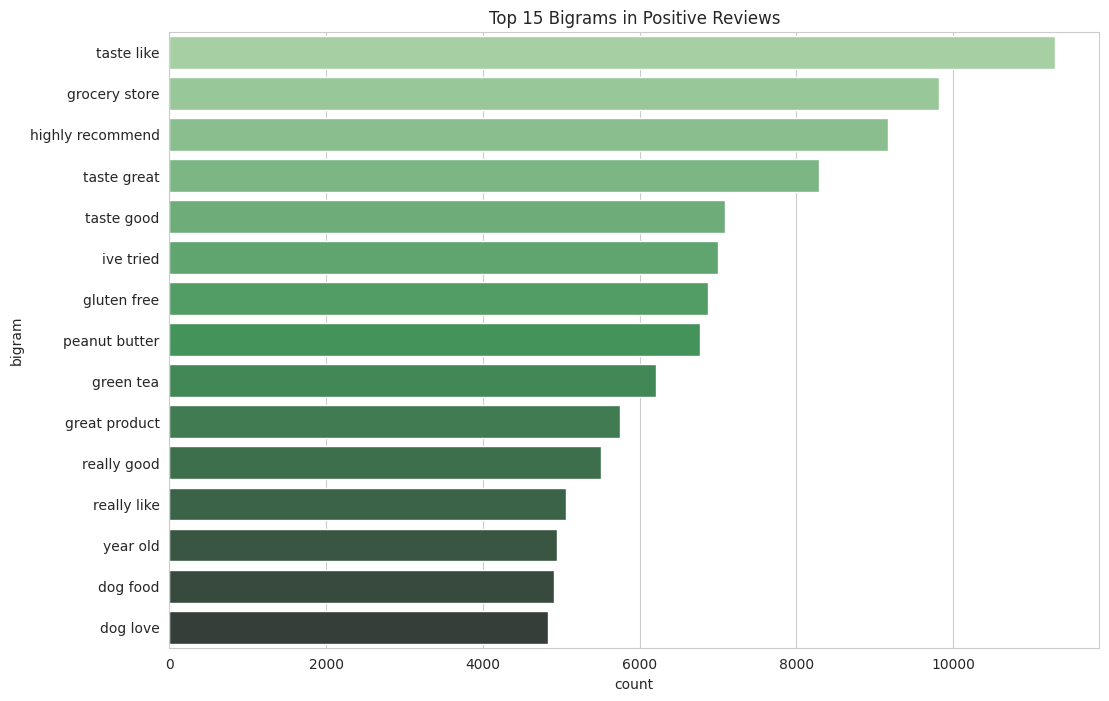

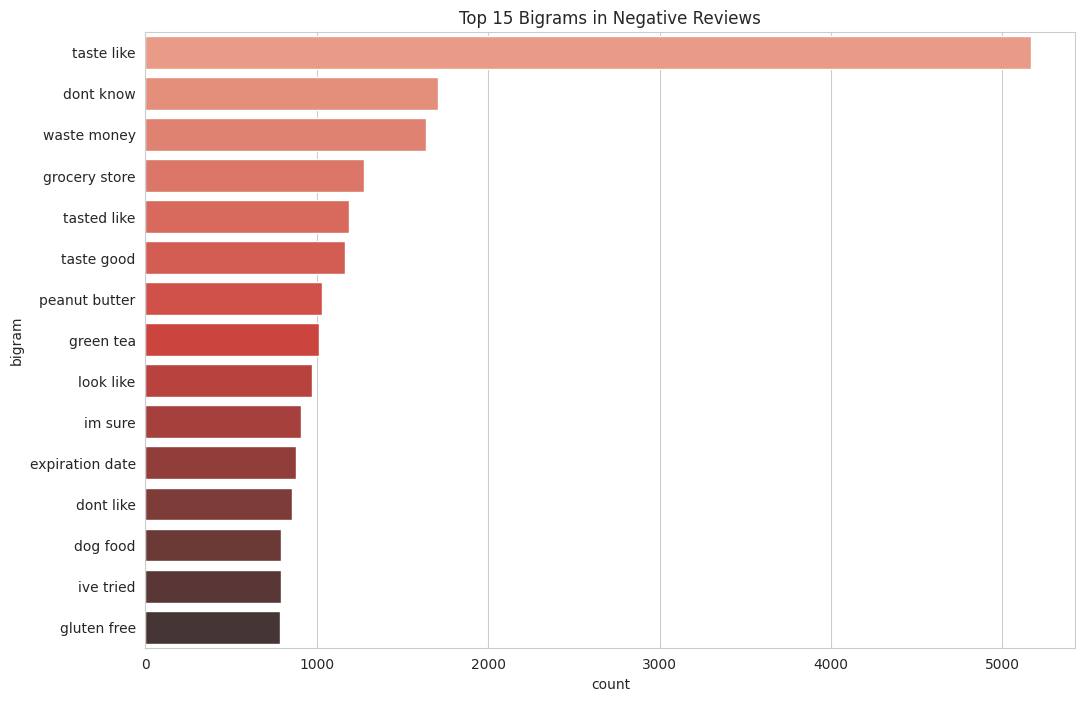

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Separate positive and negative reviews from the df_filtered
positive_reviews = df_filtered[df_filtered['Sentiment'] == 1]['CleanedText']
negative_reviews = df_filtered[df_filtered['Sentiment'] == 0]['CleanedText']

# Helper function to get and plot top n-grams
def get_top_ngrams(corpus, ngram_range=(2, 2), n=15):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Getting and plotting the top bigrams for positive reviews
top_positive_bigrams = get_top_ngrams(positive_reviews)
p_df = pd.DataFrame(top_positive_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=p_df, palette='Greens_d')
plt.title('Top 15 Bigrams in Positive Reviews')
plt.show()

# Plotting the top bigrams for negative reviews
top_negative_bigrams = get_top_ngrams(negative_reviews)
n_df = pd.DataFrame(top_negative_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=n_df, palette='Reds_d')
plt.title('Top 15 Bigrams in Negative Reviews')
plt.show()

# Data Preparation

### Train-Test Split

In [16]:
X = df_filtered['CleanedText'].values
y = df_filtered['Sentiment'].values

# First split: 80% train+val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Second split: 75% of remainder for train, 25% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set size:   {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size:       {len(X_test)}")

Training set size:   214128
Validation set size: 71377
Test set size:       71377


### Text Vectorization

In [17]:
MAX_TOKENS = 20000
MAX_LEN = 150
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='int', output_sequence_length=MAX_LEN)

print("Adapting vectorizer to training data")
vectorizer.adapt(X_train)

Adapting vectorizer to training data


2025-07-22 23:44:50.964291: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Model Building

### Building the LSTM Model

In [18]:
input_layer = Input(shape=(1,), dtype=tf.string)
vec_layer = vectorizer(input_layer)
embedding_layer = Embedding(input_dim=MAX_TOKENS + 1, output_dim=128)
model_body = embedding_layer(vec_layer)
model_body = Bidirectional(LSTM(64))(model_body)
model_body = Dropout(0.5)(model_body)
output_layer = Dense(1, activation='sigmoid')(model_body)

model = Model(inputs=input_layer, outputs=output_layer)

### Model Compilation

In [19]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 150)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 128)       │     2,560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,073 (10.14 MB)

 Trainable params: 2,659,073 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

### Defining constraints for smart training

In [20]:
# Defining EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

# Calculating class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weight_dict}")

Class Weights: {0: 3.1965128082641665, 1: 0.5927123354407254}


### Training the Model

In [21]:
print("Starting model training")
history = model.fit(
    tf.constant(X_train),
    y_train,
    validation_data=(tf.constant(X_val), y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)
print("Model training complete.")

Starting model training
Epoch 1/10
3346/3346 ━━━━━━━━━━━━━━━━━━━━ 600s 178ms/step - accuracy: 0.8173 - loss: 0.3817 - val_accuracy: 0.8628 - val_loss: 0.3665
Epoch 2/10
3346/3346 ━━━━━━━━━━━━━━━━━━━━ 564s 169ms/step - accuracy: 0.9041 - loss: 0.2317 - val_accuracy: 0.8896 - val_loss: 0.2508
Epoch 3/10
3346/3346 ━━━━━━━━━━━━━━━━━━━━ 622s 169ms/step - accuracy: 0.9254 - loss: 0.1823 - val_accuracy: 0.9051 - val_loss: 0.2394
Epoch 4/10
3346/3346 ━━━━━━━━━━━━━━━━━━━━ 571s 171ms/step - accuracy: 0.9398 - loss: 0.1477 - val_accuracy: 0.9130 - val_loss: 0.2354
Epoch 5/10
3346/3346 ━━━━━━━━━━━━━━━━━━━━ 568s 170ms/step - accuracy: 0.9519 - loss: 0.1168 - val_accuracy: 0.9049 - val_loss: 0.2619
Epoch 6/10
3346/3346 ━━━━━━━━━━━━━━━━━━━━ 567s 169ms/step - accuracy: 0.9603 - loss: 0.0961 - val_accuracy: 0.8847 - val_loss: 0.3606
Model training complete.


# Model Evaluation

### Evaluation & ROC Curve and AUC Score

2231/2231 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.69      0.83      0.75     11165
    Positive       0.97      0.93      0.95     60212

    accuracy                           0.91     71377
   macro avg       0.83      0.88      0.85     71377
weighted avg       0.92      0.91      0.92     71377


--- Confusion Matrix ---


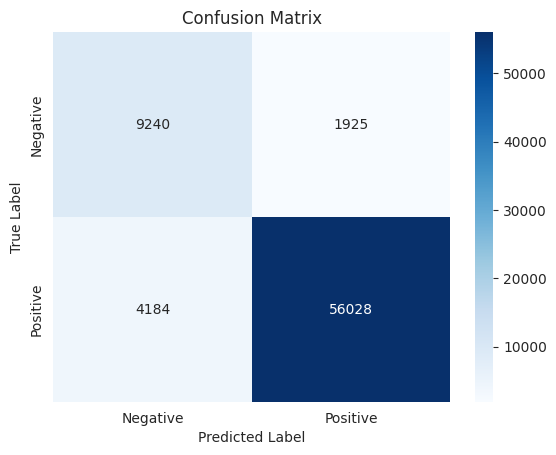


 ROC Curve 


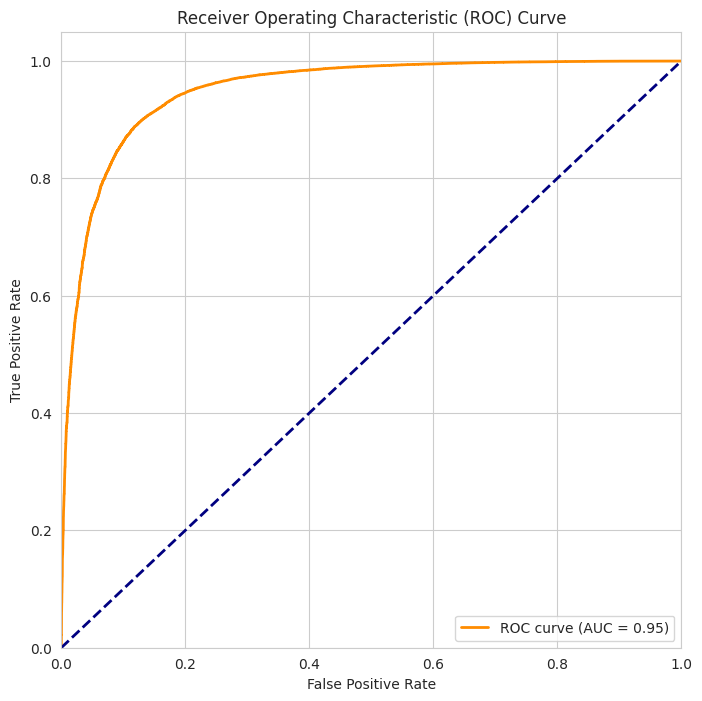

In [22]:
from sklearn.metrics import roc_curve, auc

# Making predictions on the test set
y_pred_probs = model.predict(tf.constant(X_test))
y_pred = (y_pred_probs > 0.5).astype(int)

# Printing classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Plotting the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\n ROC Curve ")
# Calculating the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Insights from the prediction

### Inference Function

In [23]:
def predict_sentiment(review_text):
    # Cleaning the input text
    cleaned_text = clean_text_nltk(review_text)
    # The model expects a batch, so I would have to wrap the text in a list
    input_tensor = tf.constant([cleaned_text])
    # Making a prediction
    prediction = model.predict(input_tensor)[0][0]
    
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if sentiment == "Positive" else 1 - prediction
    
    print(f"Sentiment: {sentiment} (Confidence: {confidence:.2%})")

print("Inference function is ready.")

Inference function is ready.


### Testing the Inference Function

In [24]:
predict_sentiment("This was the best coffee I have ever had, absolutely fantastic!")
predict_sentiment("The product arrived late and was completely stale. A total waste of money.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sentiment: Positive (Confidence: 99.76%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Sentiment: Negative (Confidence: 99.87%)


### Trying prediction on Bulk Data

In [25]:
# Creating a list of new, unseen reviews (I used some common reviews for this "bulk data")
new_reviews = [
    "This coffee has a rich and bold flavor. I will definitely buy it again.",
    "The product arrived with the seal broken and it seems stale. Very disappointed.",
    "It's an okay snack, nothing special but not bad either.",
    "An absolute masterpiece of a cookie! My whole family loved them.",
    "I was expecting a lot more for the price. The taste is bland and forgettable."
]

# Cleaning the list of reviews using the same function as before
cleaned_reviews = [clean_text_nltk(review) for review in new_reviews]

# Converting the list to a TensorFlow Tensor for the model
input_tensor = tf.constant(cleaned_reviews)

# Making predictions on the entire batch
pred_probs = model.predict(input_tensor)

# Converting probabilities to final labels
pred_labels = (pred_probs > 0.5).astype(int).flatten()
sentiment_map = {1: 'Positive', 0: 'Negative'}
predicted_sentiments = [sentiment_map[label] for label in pred_labels]

# Display the results in a DataFrame
results_df = pd.DataFrame({
    'Review Text': new_reviews,
    'Predicted Sentiment': predicted_sentiments,
    'Confidence Score': pred_probs.flatten()
})

from IPython.display import display
display(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


,Review Text,Predicted Sentiment,Confidence Score
0,This coffee has a rich and bold flavor. I will...,Positive,0.885819
1,The product arrived with the seal broken and i...,Negative,0.018696
2,"It's an okay snack, nothing special but not ba...",Negative,0.059893
3,An absolute masterpiece of a cookie! My whole ...,Positive,0.999507
4,I was expecting a lot more for the price. The ...,Negative,0.006899
